In [3]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


In [4]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils 
import seaborn as sns
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, confusion_matrix
import keras

## **Data Loading**

In [9]:
#Unzip data
!unzip '/content/drive/MyDrive/Brain Tumor Detection/brain tumor dataset.zip'

Archive:  /content/drive/MyDrive/Brain Tumor Detection/brain tumor dataset.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflati

In [10]:
#Count images in the two folders: yes (Tumor) and no (Healthey)
root =  '/content/brain_tumor_dataset'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img 

{'no': 98, 'yes': 155}

So we have 155 Brain MRI images with a tumor and 98 healthey ones. 

Text(0.5, 1.0, 'no')

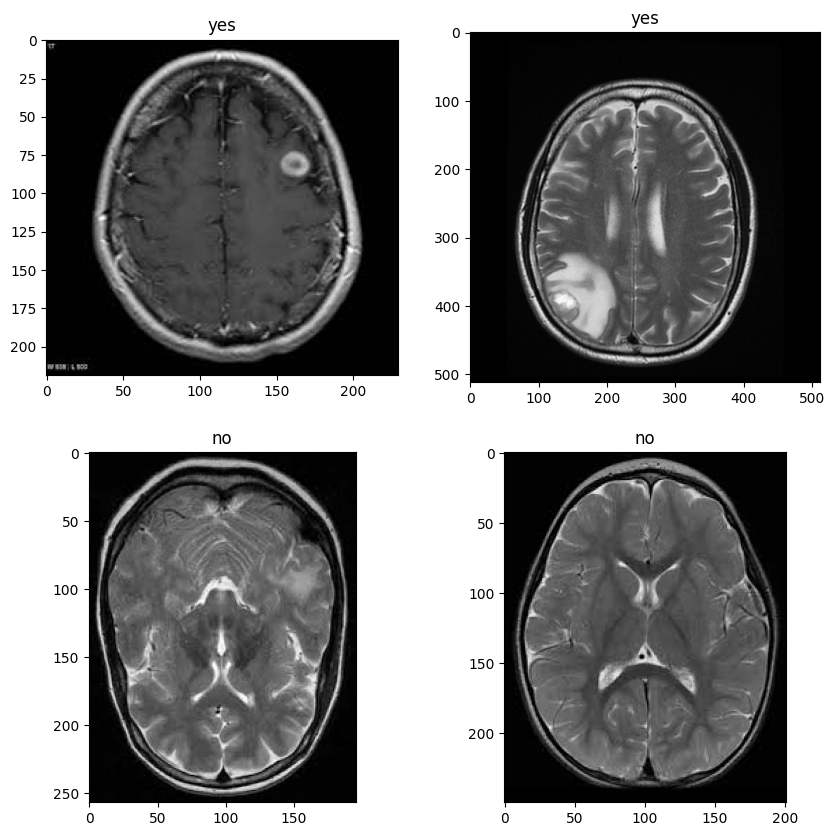

In [11]:
#Plot some MRI images
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(load_img(os.path.join('yes', os.listdir('yes')[0])))
plt.title('yes')
plt.subplot(2, 2, 2)
plt.imshow(load_img(os.path.join('yes', os.listdir('yes')[1])))
plt.title('yes')

plt.subplot(2, 2, 3)
plt.imshow(load_img(os.path.join('no', os.listdir('no')[0])))
plt.title('no')
plt.subplot(2, 2, 4)
plt.imshow(load_img(os.path.join('no', os.listdir('no')[1])))
plt.title('no')

## **Image Augmentation**

As much as our training set contains more data, the model's accuracy will improve. Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of already existing data.

In [12]:
#Define a function for image augmentation
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest',
                                  rescale= 1/255
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [13]:
#Create augmented images folders
#L = ['aug_train', 'aug_test', 'aug_val']
name = 'aug_data'
if not os.path.exists("./"+name):
  os.mkdir("./"+name)
  for dir in os.listdir(root):
    os.makedirs("./"+name+"/"+dir)
else:
  print(f"{name} Already exists")

In [14]:
#Augment data for the examples with the label 'yes' in the training set
augment_data(file_dir='./brain_tumor_dataset/yes',n_generated_samples=8, save_to_dir='./aug_data/yes')
#Augment data for the examples with the label 'no' in the training set
augment_data(file_dir='./brain_tumor_dataset/no', n_generated_samples=12, save_to_dir='./aug_data/no')


## **Split data into train, validation and test sets**

In [30]:
#Count images in the two folders: yes (Tumor) and no (Healthey) in the folder of augmented images
root =  '/content/aug_data'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img 

{'no': 1, 'yes': 1}

In [31]:
#Define a function that creates new folders for the train, test and val sets and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [32]:
#Create the training set
create_folders('train', 0.7)

train Already exists


In [33]:
#Create the test set
create_folders('test', 0.15)

test Already exists


In [34]:
#Create the validation set
create_folders('val', 0.15)

val Already exists


In [35]:
#Define a function that counts images in the folders: yes (Tumor) and no (Healthey)
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [36]:
#Count images in the training set
count_img('train')

{'no': 891, 'yes': 976}

In [37]:
#Count images in the test set
count_img('test')

{'no': 191, 'yes': 209}

In [38]:
#Count images in the validation set
count_img('val')

{'no': 191, 'yes': 209}

In [39]:
# #Define a function for image augmentation
# def augment_data2(file_dir, n_generated_samples, save_to_dir):
#     data_gen = ImageDataGenerator(rescale = 1/255)

#     for filename in os.listdir(file_dir):
#         image = cv2.imread(file_dir + '/' + filename)
#         # reshape the image
#         image = image.reshape((1,)+image.shape)
#         save_prefix = 'aug_' + filename[:-4]
#         i=0
#         for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
#                 i += 1
#                 if i > n_generated_samples:
#                     break

In [40]:
# #Augment data for the examples with the label 'yes' in the test set
# augment_data2(file_dir='./test/yes',n_generated_samples=8, save_to_dir='./aug_test/yes')
# #Augment data for the examples with the label 'no' in the training set
# augment_data2(file_dir='./test/no', n_generated_samples=12, save_to_dir='./aug_test/no')

In [41]:
# #Augment data for the examples with the label 'yes' in the validation set
# augment_data2(file_dir='./val/yes',n_generated_samples=8, save_to_dir='./aug_val/yes')
# #Augment data for the examples with the label 'no' in the training set
# augment_data2(file_dir='./val/no', n_generated_samples=12, save_to_dir='./aug_val/no')

In [42]:
# #Count images in the training set
# count_img('aug_train')

In [43]:
# #Count images in the training set
# count_img('aug_test')

In [44]:
# #Count images in the training set
# count_img('aug_val')

## **Image Preprocessing**

In [45]:
#Define a function that crop tha brain contour
def crop_brain_contour(image, plot=False):
    
    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [ ]:
# #Example
# ex_img = cv2.imread('/content/drive/MyDrive/Brain Tumor Detection/N/030 (1).jpg')
# img = crop_brain_contour(ex_img, plot=True)

In [47]:
#Define a function that load data
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [48]:
#Load trainig data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['/content/train/yes', '/content/train/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1867
X shape is: (1867, 240, 240, 3)
y shape is: (1867, 1)


In [49]:
#Define a function that plot images
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

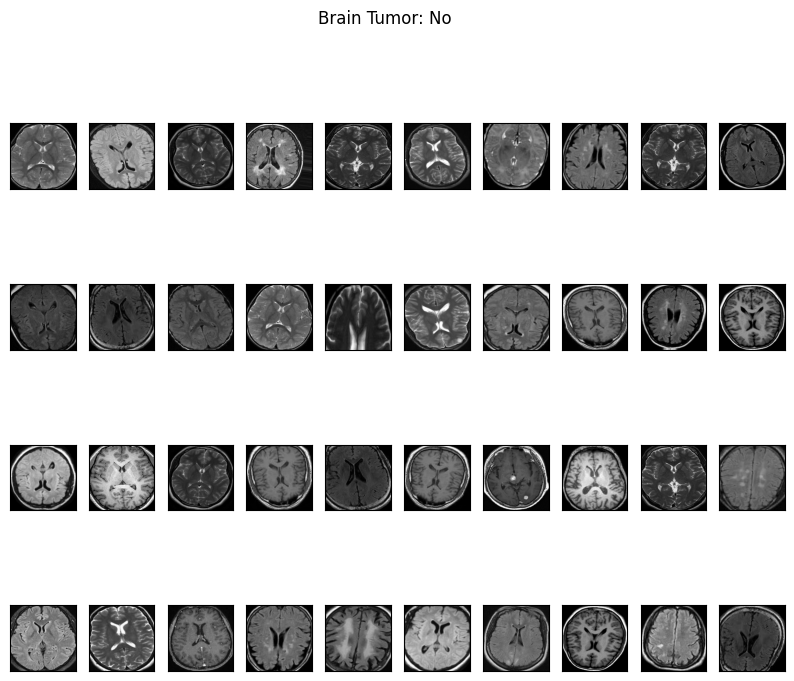

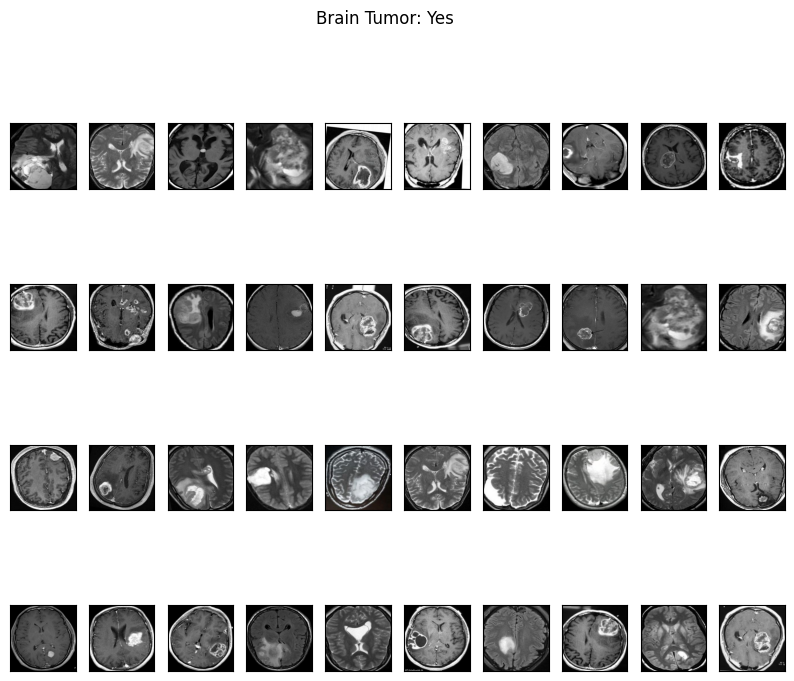

In [50]:
#Plot samples from the training set
plot_sample_images(X_train, y_train)

We can notice that the noise has been deleted and some images look alike with some slight changes resulted from the data augmentation

In [51]:
#Load test data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['/content/test/yes', '/content/test/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 400
X shape is: (400, 240, 240, 3)
y shape is: (400, 1)


In [52]:
#Load validation data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['/content/val/yes', '/content/val/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 400
X shape is: (400, 240, 240, 3)
y shape is: (400, 1)


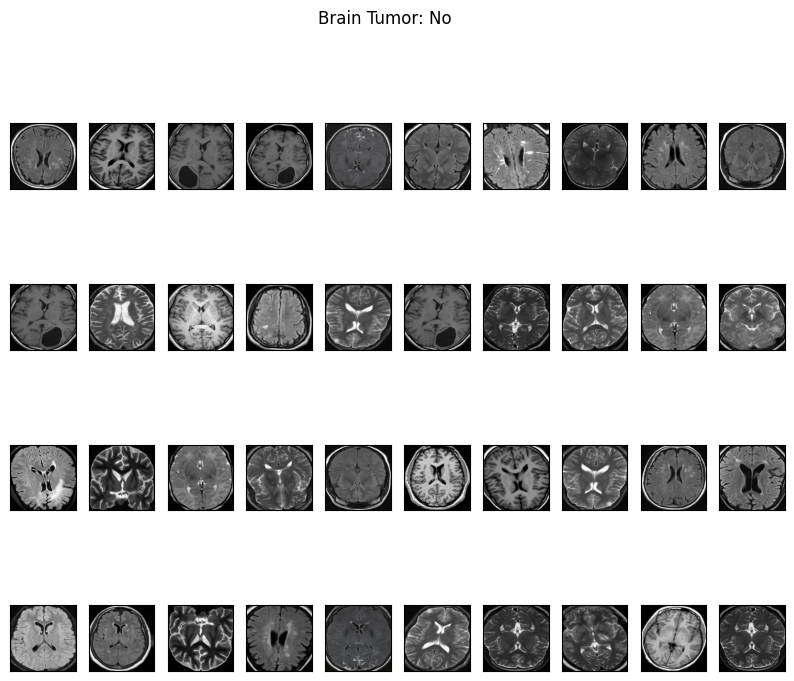

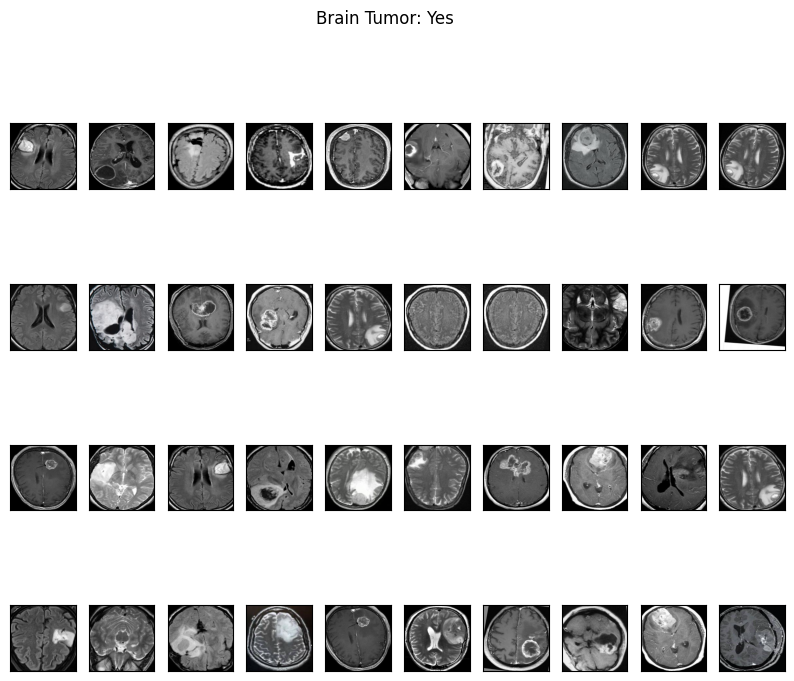

In [53]:
#Plot samples from the validation set
plot_sample_images(X_val, y_val)

## **CNN Model**

In [54]:
#Build our model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25)) 
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 236, 236, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 118, 118, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       7

In [55]:
#Compile our model
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [56]:
#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [57]:
#Train our model
hist = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.6363
Epoch 1: val_accuracy improved from -inf to 0.70250, saving model to ./bestmodel.h5
59/59 [==============================] - 23s 163ms/step - loss: 0.6467 - accuracy: 0.6363 - val_loss: 0.5542 - val_accuracy: 0.7025
Epoch 2/30
58/59 [============================>.] - ETA: 0s - loss: 0.4666 - accuracy: 0.7953
Epoch 2: val_accuracy improved from 0.70250 to 0.79750, saving model to ./bestmodel.h5
59/59 [==============================] - 7s 125ms/step - loss: 0.4668 - accuracy: 0.7949 - val_loss: 0.4566 - val_accuracy: 0.7975
Epoch 3/30
58/59 [============================>.] - ETA: 0s - loss: 0.3551 - accuracy: 0.8534
Epoch 3: val_accuracy improved from 0.79750 to 0.84750, saving model to ./bestmodel.h5
59/59 [==============================] - 8s 128ms/step - loss: 0.3572 - accuracy: 0.8527 - val_loss: 0.3654 - val_accuracy: 0.8475
Epoch 4/30
58/59 [============================>.] - ETA: 0s - loss

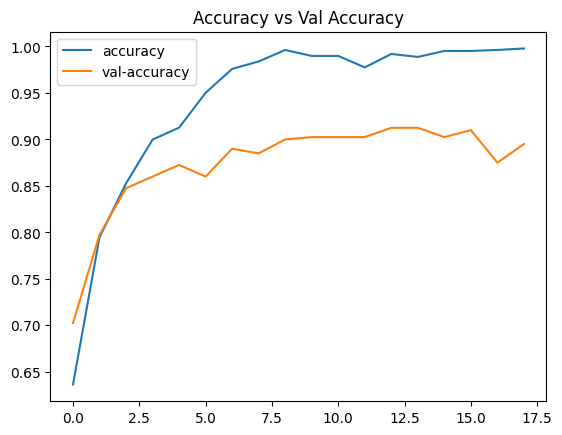

In [58]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

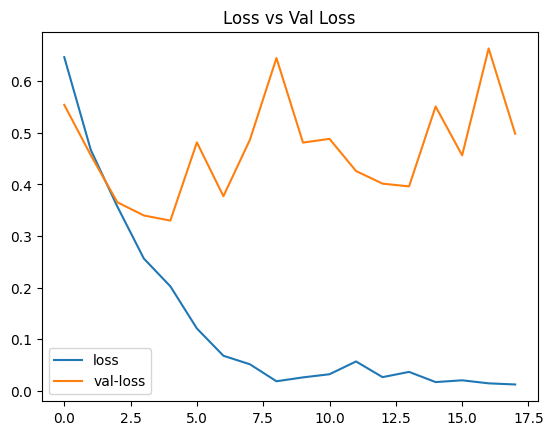

In [59]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

13/13 [==============================] - 1s 32ms/step
Accuracy = 0.915000
[[169  22]
 [ 12 197]]


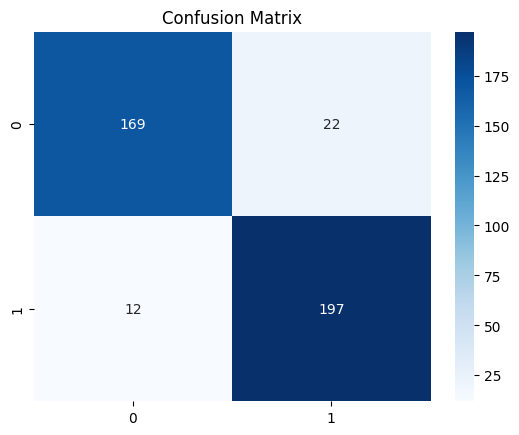

In [60]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the saved model
from keras.models import load_model
model = load_model('/content/bestmodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = %f'%accuracy)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
sns.heatmap(cm,annot=True, cmap="Blues", fmt="d",cbar=True, annot_kws={"size":10})
plt.title('Confusion Matrix') 

print(cm)

In [61]:
from sklearn.metrics import classification_report
import numpy as np

# Load the saved model
model = load_model('/content/bestmodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)

# Compute classification report
report = classification_report(y_test, y_pred, digits=4)
print(report)

13/13 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

           0     0.9337    0.8848    0.9086       191
           1     0.8995    0.9426    0.9206       209

    accuracy                         0.9150       400
   macro avg     0.9166    0.9137    0.9146       400
weighted avg     0.9159    0.9150    0.9149       400



In [62]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/bestmodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 0s 25ms/step - loss: 0.3860 - accuracy: 0.9150
The accuracy of our model is 0.9150000214576721


We can see that our model works well on the test set, so it's not overfitted

In [63]:
!pip install image-keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.1 MB/s eta 0:00:00


In [87]:
#Try our model on a random image that it has never seen before
from keras_preprocessing.image import load_img, img_to_array
#Choose a MRI image 
path = "/content/drive/MyDrive/Brain Tumor Detection/Y/Y27.jpg"
img_yes = load_img(path, target_size=(240,240))
img_array_yes = img_to_array(img_yes)/255
img_array_yes = np.expand_dims(img_array_yes, axis=0)
prediction1 = model.predict(img_array_yes)
class1 = np.round(prediction1).astype(int)
if class1 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

1/1 [==============================] - 0s 32ms/step
The MRI image has a tumor


## **Keras Applications**

In [ ]:
!pip install Keras-Applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


## **Transfer Learning**

## **MobileNet**

In [67]:
#Import MobileNet Model
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(240,240,3), include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [68]:
#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False

In [69]:
#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)

In [70]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 120, 120, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 120, 120, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 120, 120, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 120, 120, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 120, 120, 32)     128       
 ation)                                                      

In [71]:
#Compile the new model
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [72]:
#Early stopping and model checkpoint
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cdt = [est, mct]

In [73]:
#Fit our new model
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)

Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 3.3685 - accuracy: 0.8061
Epoch 1: val_accuracy improved from -inf to 0.95000, saving model to ./besttransfermodel.h5
59/59 [==============================] - 8s 90ms/step - loss: 3.3685 - accuracy: 0.8061 - val_loss: 0.1957 - val_accuracy: 0.9500
Epoch 2/30
58/59 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.9450
Epoch 2: val_accuracy improved from 0.95000 to 0.96000, saving model to ./besttransfermodel.h5
59/59 [==============================] - 4s 61ms/step - loss: 0.6662 - accuracy: 0.9454 - val_loss: 0.1387 - val_accuracy: 0.9600
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 0.3730 - accuracy: 0.9668
Epoch 3: val_accuracy did not improve from 0.96000
59/59 [==============================] - 3s 55ms/step - loss: 0.3730 - accuracy: 0.9668 - val_loss: 8.3122 - val_accuracy: 0.5375
Epoch 4/30
59/59 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.9

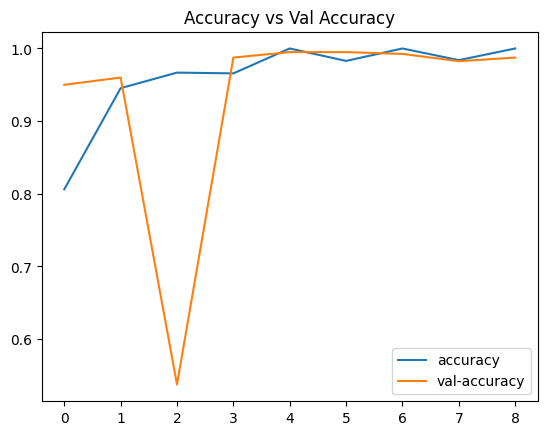

In [74]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

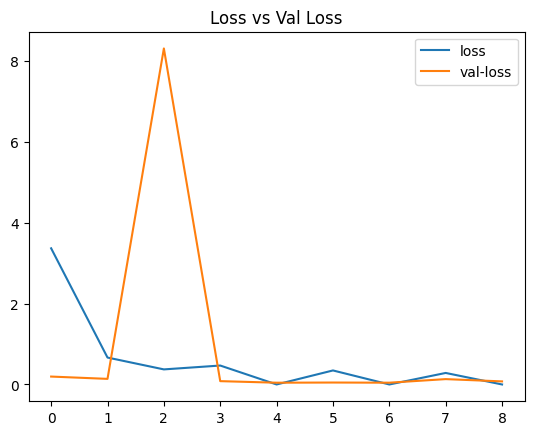

In [75]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

13/13 [==============================] - 1s 47ms/step
Accuracy = 0.992500
[[189   2]
 [  1 208]]


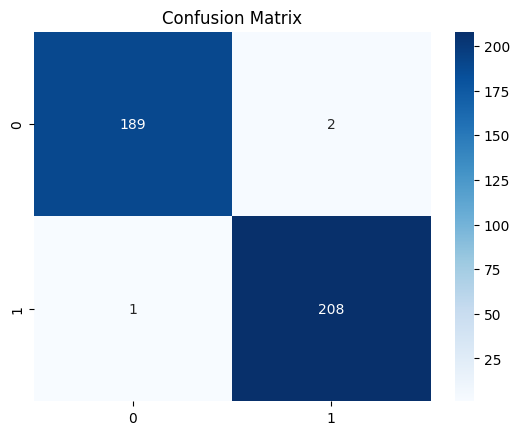

In [76]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the saved model
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = %f'%accuracy)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
sns.heatmap(cm,annot=True, cmap="Blues", fmt="d",cbar=True, annot_kws={"size":10})
plt.title('Confusion Matrix') 

print(cm)

In [77]:
from sklearn.metrics import classification_report
import numpy as np

# Load the saved model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)

# Compute classification report
report = classification_report(y_test, y_pred, digits=4)
print(report)

13/13 [==============================] - 1s 43ms/step
              precision    recall  f1-score   support

           0     0.9947    0.9895    0.9921       191
           1     0.9905    0.9952    0.9928       209

    accuracy                         0.9925       400
   macro avg     0.9926    0.9924    0.9925       400
weighted avg     0.9925    0.9925    0.9925       400



In [78]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 1s 45ms/step - loss: 0.0104 - accuracy: 0.9925
The accuracy of our model is 0.9925000071525574


In [85]:
#Try our model on a random image that it has never seen before
from keras_preprocessing.image import load_img, img_to_array
#Choose a MRI image 
path = "/content/drive/MyDrive/Brain Tumor Detection/N/33 no.jpg"
img_yes = load_img(path, target_size=(240,240))
img_array_yes = img_to_array(img_yes)/255
img_array_yes = np.expand_dims(img_array_yes, axis=0)
prediction1 = model.predict(img_array_yes)
class1 = np.round(prediction1).astype(int)
if class1 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

1/1 [==============================] - 0s 22ms/step
The MRI image has a tumor


# **Xception Model**

In [ ]:
#Import MobileNet Model
from keras.applications.xception import Xception
base_model_X = Xception(input_shape=(240,240,3), include_top=False)

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
#Make the layers of the model untrainable
for layer in base_model_X.layers:
  layer.trainable = False

In [ ]:
#Add a flatten and dense layers to the base model
X = Flatten()(base_model_X.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model_X.input, X)

In [ ]:
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 119, 119, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 119, 119, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
#Compile the new model
transfer_model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
#Early stopping and model checkpoint
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cdt = [est, mct]

In [ ]:
#Fit our new model
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)

Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 0.7322 - accuracy: 0.8409
Epoch 1: val_accuracy improved from -inf to 0.95500, saving model to ./besttransfermodel.h5
59/59 [==============================] - 26s 326ms/step - loss: 0.7322 - accuracy: 0.8409 - val_loss: 0.1449 - val_accuracy: 0.9550
Epoch 2/30
59/59 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9791
Epoch 2: val_accuracy improved from 0.95500 to 0.98500, saving model to ./besttransfermodel.h5
59/59 [==============================] - 12s 208ms/step - loss: 0.0547 - accuracy: 0.9791 - val_loss: 0.0562 - val_accuracy: 0.9850
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9968
Epoch 3: val_accuracy did not improve from 0.98500
59/59 [==============================] - 12s 197ms/step - loss: 0.0160 - accuracy: 0.9968 - val_loss: 0.0592 - val_accuracy: 0.9725
Epoch 4/30
59/59 [==============================] - ETA: 0s - loss: 0.0058 - accurac

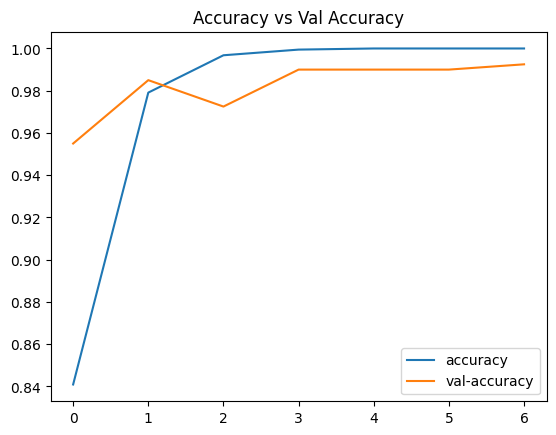

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

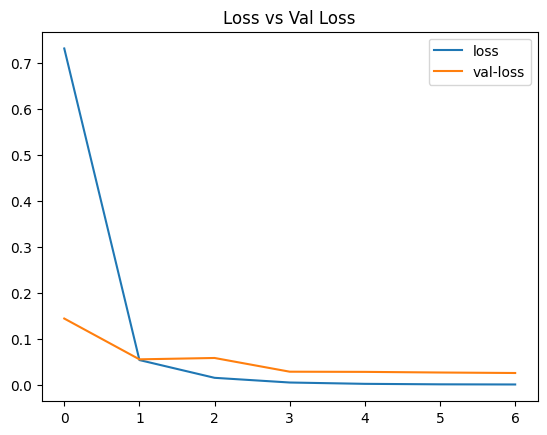

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

13/13 [==============================] - 3s 153ms/step
Accuracy = 0.987500
[[190   1]
 [  4 205]]


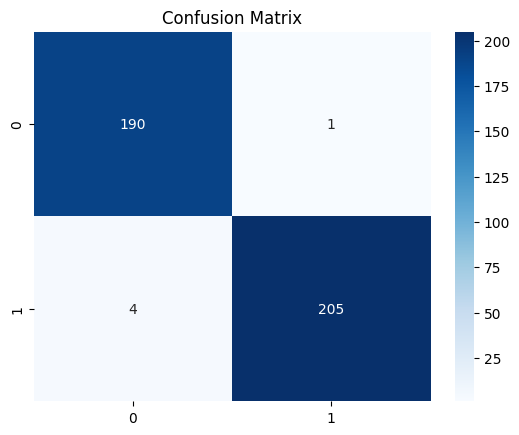

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the saved model
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = %f'%accuracy)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
sns.heatmap(cm,annot=True, cmap="Blues", fmt="d",cbar=True, annot_kws={"size":10})
plt.title('Confusion Matrix') 

print(cm)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Load the saved model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)

# Compute classification report
report = classification_report(y_test, y_pred, digits=4)
print(report)

13/13 [==============================] - 3s 152ms/step
              precision    recall  f1-score   support

           0     0.9794    0.9948    0.9870       191
           1     0.9951    0.9809    0.9880       209

    accuracy                         0.9875       400
   macro avg     0.9873    0.9878    0.9875       400
weighted avg     0.9876    0.9875    0.9875       400



In [ ]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 3s 150ms/step - loss: 0.0683 - accuracy: 0.9875
The accuracy of our model is 0.987500011920929


# **VGG16**

In [ ]:
#Import MobileNet Model
from keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape=(240,240,3), include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)

In [ ]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [ ]:
#Compile the new model
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
#Early stopping and model checkpoint
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cdt = [est, mct]

In [ ]:
#Fit our new model
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)

Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 0.7854 - accuracy: 0.6577
Epoch 1: val_accuracy improved from -inf to 0.88221, saving model to ./besttransfermodel.h5
59/59 [==============================] - 26s 334ms/step - loss: 0.7854 - accuracy: 0.6577 - val_loss: 0.2985 - val_accuracy: 0.8822
Epoch 2/30
59/59 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8157
Epoch 2: val_accuracy improved from 0.88221 to 0.91228, saving model to ./besttransfermodel.h5
59/59 [==============================] - 12s 205ms/step - loss: 0.3811 - accuracy: 0.8157 - val_loss: 0.2126 - val_accuracy: 0.9123
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 0.3031 - accuracy: 0.8704
Epoch 3: val_accuracy improved from 0.91228 to 0.95238, saving model to ./besttransfermodel.h5
59/59 [==============================] - 12s 201ms/step - loss: 0.3031 - accuracy: 0.8704 - val_loss: 0.1466 - val_accuracy: 0.9524
Epoch 4/30
59/59 [======================

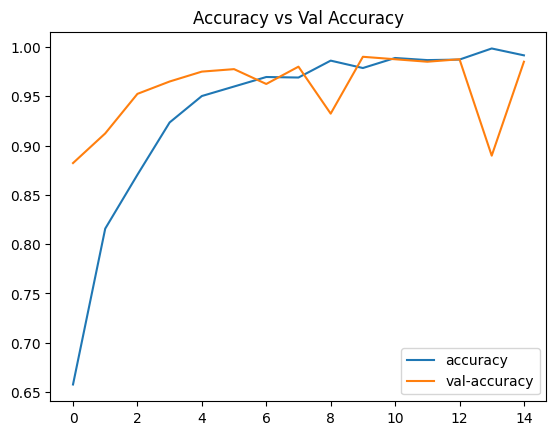

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

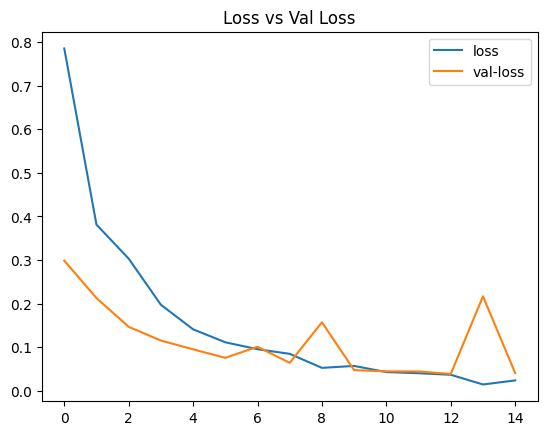

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

13/13 [==============================] - 2s 156ms/step
Accuracy = 0.972431
[[187   3]
 [  8 201]]


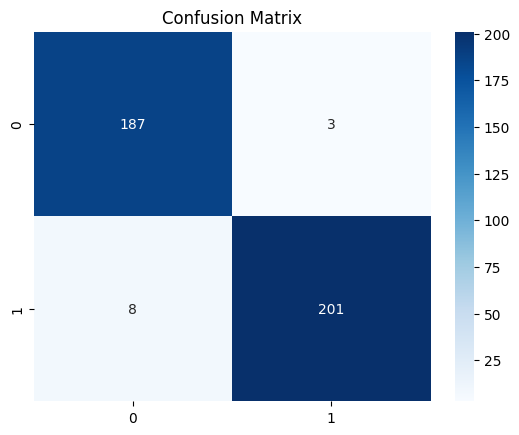

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the saved model
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = %f'%accuracy)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
sns.heatmap(cm,annot=True, cmap="Blues", fmt="d",cbar=True, annot_kws={"size":10})
plt.title('Confusion Matrix') 

print(cm)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Load the saved model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)

# Compute classification report
report = classification_report(y_test, y_pred, digits=4)
print(report)

13/13 [==============================] - 2s 153ms/step
              precision    recall  f1-score   support

           0     0.9590    0.9842    0.9714       190
           1     0.9853    0.9617    0.9734       209

    accuracy                         0.9724       399
   macro avg     0.9721    0.9730    0.9724       399
weighted avg     0.9728    0.9724    0.9724       399



In [ ]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 2s 152ms/step - loss: 0.0789 - accuracy: 0.9724
The accuracy of our model is 0.9724310636520386


# **VGG19**

In [ ]:
#Import MobileNet Model
from keras.applications.vgg19 import VGG19
base_model = VGG19(input_shape=(240,240,3), include_top=False)

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)

In [ ]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [ ]:
#Compile the new model
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
#Early stopping and model checkpoint
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cdt = [est, mct]

In [ ]:
#Fit our new model
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)

Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 0.9880 - accuracy: 0.6286
Epoch 1: val_accuracy improved from -inf to 0.85750, saving model to ./besttransfermodel.h5
59/59 [==============================] - 32s 442ms/step - loss: 0.9880 - accuracy: 0.6286 - val_loss: 0.3799 - val_accuracy: 0.8575
Epoch 2/30
59/59 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.7792
Epoch 2: val_accuracy improved from 0.85750 to 0.88500, saving model to ./besttransfermodel.h5
59/59 [==============================] - 15s 248ms/step - loss: 0.5103 - accuracy: 0.7792 - val_loss: 0.2670 - val_accuracy: 0.8850
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 0.3848 - accuracy: 0.8258
Epoch 3: val_accuracy did not improve from 0.88500
59/59 [==============================] - 14s 240ms/step - loss: 0.3848 - accuracy: 0.8258 - val_loss: 0.7165 - val_accuracy: 0.6750
Epoch 4/30
59/59 [==============================] - ETA: 0s - loss: 0.2782 - accurac

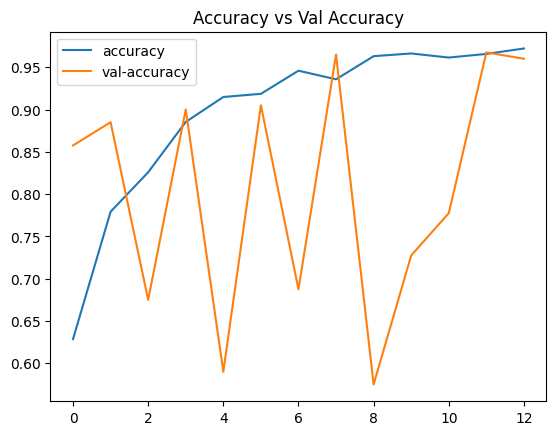

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

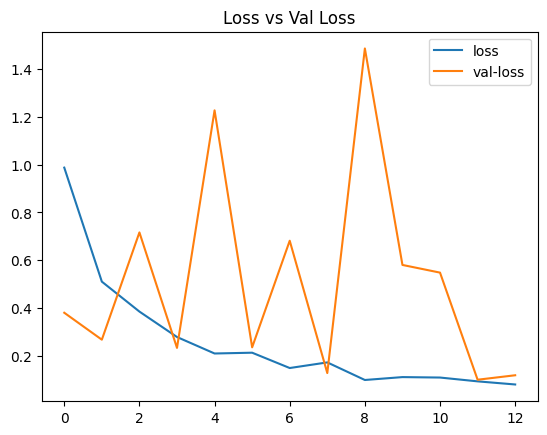

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

13/13 [==============================] - 2s 189ms/step
Accuracy = 0.960000
[[187   4]
 [ 12 197]]


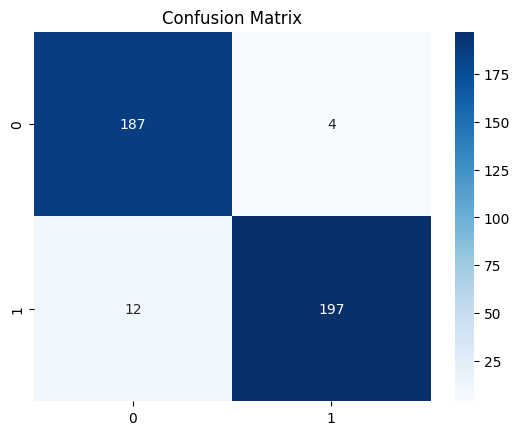

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the saved model
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = %f'%accuracy)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
sns.heatmap(cm,annot=True, cmap="Blues", fmt="d",cbar=True, annot_kws={"size":10})
plt.title('Confusion Matrix') 

print(cm)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Load the saved model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)

# Compute classification report
report = classification_report(y_test, y_pred, digits=4)
print(report)

13/13 [==============================] - 2s 188ms/step
              precision    recall  f1-score   support

           0     0.9397    0.9791    0.9590       191
           1     0.9801    0.9426    0.9610       209

    accuracy                         0.9600       400
   macro avg     0.9599    0.9608    0.9600       400
weighted avg     0.9608    0.9600    0.9600       400



In [ ]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 3s 188ms/step - loss: 0.1221 - accuracy: 0.9600
The accuracy of our model is 0.9599999785423279


# **InceptionV3**

In [ ]:
#Import MobileNet Model
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape=(240,240,3), include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)

In [ ]:
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 119, 119, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 119, 119, 32  96         ['conv2d_4[0][0]']               
 alization)                     )                                                             

In [ ]:
#Compile the new model
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
#Early stopping and model checkpoint
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cdt = [est, mct]

In [ ]:
#Fit our new model
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)

Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 2.8546 - accuracy: 0.7851
Epoch 1: val_accuracy improved from -inf to 0.94236, saving model to ./besttransfermodel.h5
59/59 [==============================] - 28s 311ms/step - loss: 2.8546 - accuracy: 0.7851 - val_loss: 0.3292 - val_accuracy: 0.9424
Epoch 2/30
58/59 [============================>.] - ETA: 0s - loss: 1.1900 - accuracy: 0.8971
Epoch 2: val_accuracy did not improve from 0.94236
59/59 [==============================] - 7s 112ms/step - loss: 1.1859 - accuracy: 0.8971 - val_loss: 1.2293 - val_accuracy: 0.8496
Epoch 3/30
58/59 [============================>.] - ETA: 0s - loss: 0.8875 - accuracy: 0.9176
Epoch 3: val_accuracy improved from 0.94236 to 0.94486, saving model to ./besttransfermodel.h5
59/59 [==============================] - 7s 119ms/step - loss: 0.8828 - accuracy: 0.9180 - val_loss: 0.3372 - val_accuracy: 0.9449
Epoch 4/30
58/59 [============================>.] - ETA: 0s - loss: 0.8536 - accuracy:

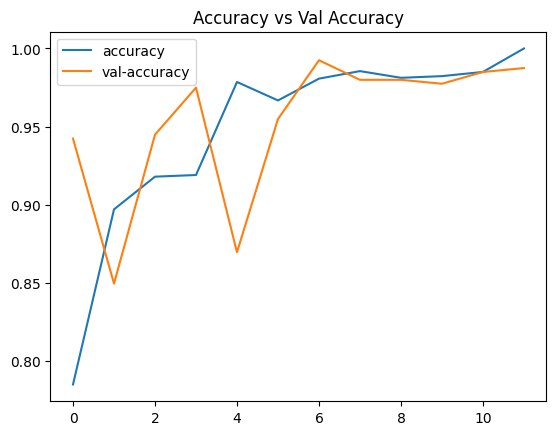

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

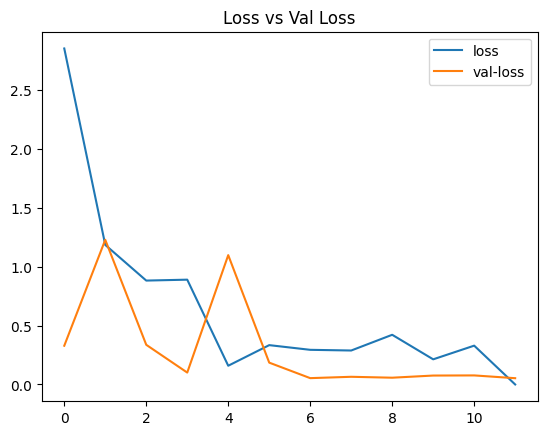

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

13/13 [==============================] - 1s 44ms/step
Accuracy = 0.994975
[[189   1]
 [  1 207]]


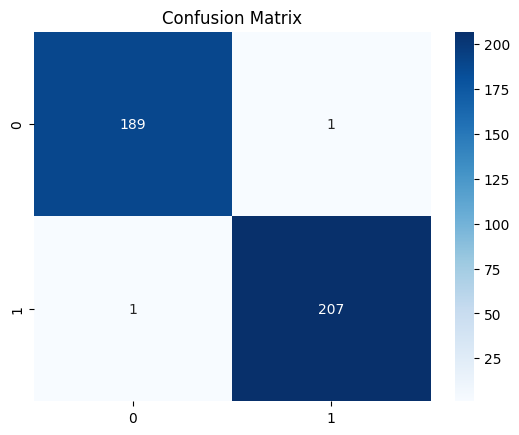

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the saved model
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = %f'%accuracy)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
sns.heatmap(cm,annot=True, cmap="Blues", fmt="d",cbar=True, annot_kws={"size":10})
plt.title('Confusion Matrix') 

print(cm)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Load the saved model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)

# Compute classification report
report = classification_report(y_test, y_pred, digits=4)
print(report)

13/13 [==============================] - 1s 44ms/step
              precision    recall  f1-score   support

           0     0.9947    0.9947    0.9947       190
           1     0.9952    0.9952    0.9952       208

    accuracy                         0.9950       398
   macro avg     0.9950    0.9950    0.9950       398
weighted avg     0.9950    0.9950    0.9950       398



In [ ]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 2s 83ms/step - loss: 0.1475 - accuracy: 0.9774
The accuracy of our model is 0.9774436354637146


# **ResNet50**

In [ ]:
#Import MobileNet Model
from keras.applications.resnet import ResNet50
base_model = ResNet50(input_shape=(240,240,3), include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)

In [ ]:
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 246, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 120, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
#Compile the new model
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
#Early stopping and model checkpoint
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cdt = [est, mct]

In [ ]:
#Fit our new model
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)

Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 3.0780 - accuracy: 0.6090
Epoch 1: val_accuracy improved from 0.58500 to 0.71000, saving model to ./besttransfermodel.h5
59/59 [==============================] - 10s 164ms/step - loss: 3.0780 - accuracy: 0.6090 - val_loss: 1.0477 - val_accuracy: 0.7100
Epoch 2/30
59/59 [==============================] - ETA: 0s - loss: 2.9937 - accuracy: 0.6176
Epoch 2: val_accuracy did not improve from 0.71000
59/59 [==============================] - 9s 146ms/step - loss: 2.9937 - accuracy: 0.6176 - val_loss: 4.3723 - val_accuracy: 0.5350
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 2.7217 - accuracy: 0.6668
Epoch 3: val_accuracy did not improve from 0.71000
59/59 [==============================] - 9s 161ms/step - loss: 2.7217 - accuracy: 0.6668 - val_loss: 1.3328 - val_accuracy: 0.6950
Epoch 4/30
59/59 [==============================] - ETA: 0s - loss: 2.7766 - accuracy: 0.6492
Epoch 4: val_accuracy improved fr

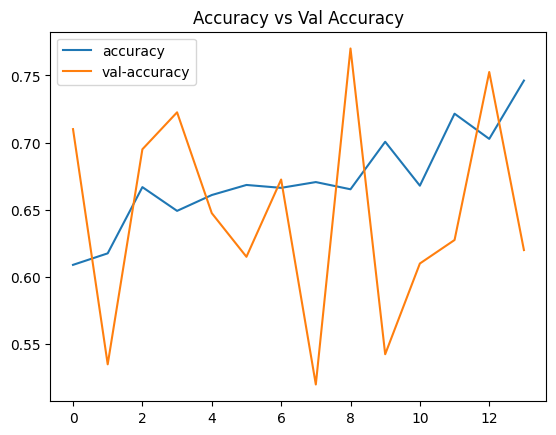

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

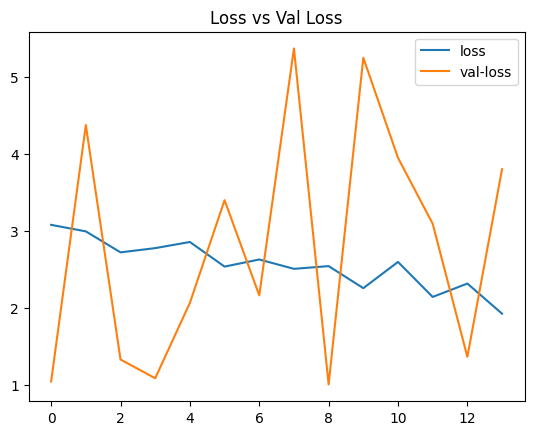

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

13/13 [==============================] - 1s 44ms/step
Accuracy = 0.994975
[[189   1]
 [  1 207]]


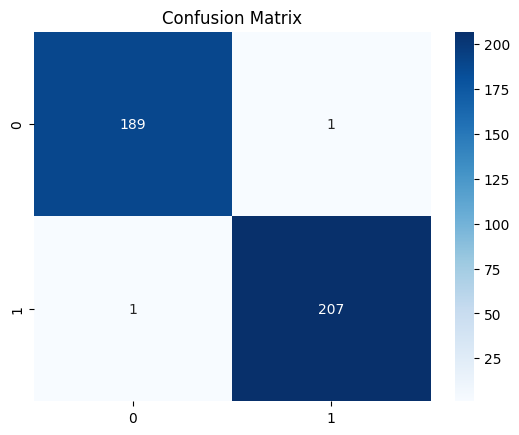

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the saved model
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy = %f'%accuracy)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
sns.heatmap(cm,annot=True, cmap="Blues", fmt="d",cbar=True, annot_kws={"size":10})
plt.title('Confusion Matrix') 

print(cm)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Load the saved model
model = load_model('/content/besttransfermodel.h5')

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred = np.round(y_pred)

# Compute classification report
report = classification_report(y_test, y_pred, digits=4)
print(report)

13/13 [==============================] - 1s 44ms/step
              precision    recall  f1-score   support

           0     0.9947    0.9947    0.9947       190
           1     0.9952    0.9952    0.9952       208

    accuracy                         0.9950       398
   macro avg     0.9950    0.9950    0.9950       398
weighted avg     0.9950    0.9950    0.9950       398



In [ ]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 3s 111ms/step - loss: 0.9912 - accuracy: 0.7800
The accuracy of our model is 0.7799999713897705
